In [1]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader

import monai
from monai.data import ITKReader, PILReader
from monai.data import  decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import Activations, AddChanneld, AsDiscrete, Compose, LoadImaged, SaveImage, ScaleIntensityd, EnsureTyped, EnsureType,SqueezeDimd,CropForegroundd


In [2]:
import matplotlib.pyplot as plt

def showImage(img_data,output_data,i):
      print(img_data.size())
      img_data = img_data.cpu().squeeze()
      output_data = output_data.cpu().squeeze()
      # img = img_data.numpy()
      # lab = lab_data.numpy()
      print(img_data.size())
      print(f"image type:{type(img_data)}\n")
      # plot the slice [:, :, 80]
      plt.figure("check",(20,20))
      plt.subplot(1, 2, 1)
      plt.title(f"image {i}")
      plt.imshow(img_data, cmap="gray")
      plt.subplot(1, 2, 2)
      plt.title(f"output {i}")
      plt.imshow(output_data)
      plt.show()

MONAI version: 0.7.dev2133
Numpy version: 1.21.1
Pytorch version: 1.9.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 20ffa3f987fad60a8428ec635fb0b4f6ccca9747

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: 3.13.0
TorchVision version: 0.10.0+cu111
tqdm version: 4.62.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.2
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

image type:<class 'torch.Tensor'>
 image shape:torch.Size([1, 1, 1024, 1024])
infer_output type:<class 'torch.Tensor'>
infer_output shape:torch.Size([1, 1, 1024, 1024])
file written: /home/xindong/project/monai-test/unet-segment2d/output2/0/0_seg.ni

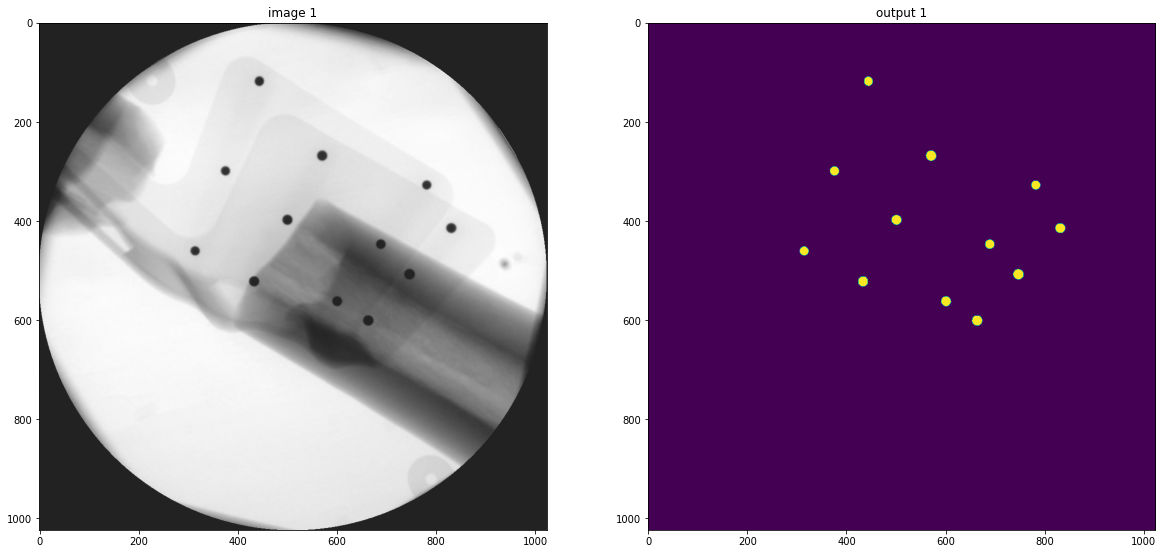

In [3]:
def main(filename):
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    file_data = {"img": filename}
    # define transforms for image and segmentation
    infer_transforms = Compose(
        [            
            LoadImaged(keys="img"),
            SqueezeDimd(keys="img", dim=-1),
            AddChanneld(keys="img"),
            ScaleIntensityd(keys="img"),
            CropForegroundd(keys="img", source_key="img"),
            EnsureTyped(keys="img"),
        ]
    )

    img_tensor = infer_transforms(file_data)
    # sliding window inference need to input 1 image in every iteration

    post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])
    saver = SaveImage(output_dir="./output2", output_ext=".nii.gz", output_postfix="seg")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(
        dimensions=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    
    model.load_state_dict(torch.load("best4_metric_model_segmentation2d_dict.pth"))

    model.eval()
    with torch.no_grad():
        image_data = img_tensor["img"].to(device)
        image_data = torch.unsqueeze(image_data, dim=0)  # 在第一维度添加维度N 因为sliding_window_inference需要 NCHW格式
        print(f"image type:{type(image_data)}\n image shape:{image_data.shape}")
        # define sliding window size and batch size for windows inference
        roi_size = (192, 192)
        sw_batch_size = 4
        infer_output = sliding_window_inference(
            image_data, roi_size, sw_batch_size, model)

        print(f"infer_output type:{type(infer_output)}\ninfer_output shape:{infer_output.shape}")
        
        infer_output = post_trans(infer_output)#后处理

        saver(infer_output)
        showImage(image_data, infer_output, 1)

if __name__ == "__main__":
    root_dir = os.getcwd()
    image_file = os.path.join(root_dir, "data/imagesTest/img512.dcm")
    main(image_file)
